# M5 Forecasting accuracy

## Introduction

This notebook is divided into four main parts:
- Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering (FE)
- Implementation

In [1]:
#!git clone https://github.com/michelevece/vece-m5-forecasting-accuracy

In [2]:
#%cd vece-m5-forecasting-accuracy/data/code

In [3]:
#%cd data

### 0) Libraries

In [1]:
# libraries
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error as mse

# my modules 
import m5_utils as utils
import m5_preprocessing as preprocessing
import m5_fe as fe

# target column
TARGET = 'sales'

# first day of the private leaderboard
D_PUBLIC = 1914
# first day of the public leaderboard
D_PRIVATE = 1942 

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'm5_fe.py',
 'm5_forecasting.ipynb',
 'm5_preprocessing.py',
 'm5_utils.py',
 '__pycache__']

## 1) Preprocessing

Data can be diveded in three main categories:
- Prices
- Calendar
- Sales

In the following:
- data is extracted;
- data undergo downcasting (in order to reduce the memory storage);
- some columns are added or removed;  
- data is stored in parquet format.

In [3]:
utils.extract_data() 

data extracted


In [4]:
calendar, prices, sales = utils.read_data_csv()

### Prices
The prices dataframe contains the price (`sell_price`) at which a product (`item_id`) is sold in a store (`store_id`) in a given week of a given year (`wm_yr_wk`).

In this dataframe, a week starts on Saturday and ends on Friday.

In [5]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [6]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [7]:
# casting
prices['store_id'] = prices['store_id'].astype('category')
prices['item_id'] = prices['item_id'].astype('category')

prices['wm_yr_wk'] = prices['wm_yr_wk'].astype('int16')  
prices['sell_price'] = prices['sell_price'].astype('float32') 

In [8]:
# missing values check
print('Missing values:', prices.isna().any().any())

print('min week:', prices['wm_yr_wk'].min())
print('max week:', prices['wm_yr_wk'].max())

Missing values: False
min week: 11101
max week: 11621


#### Release
Not all products are released in the same period. However, most of them are available since the first year

Text(0.5, 1.0, 'Release week per each item/store')

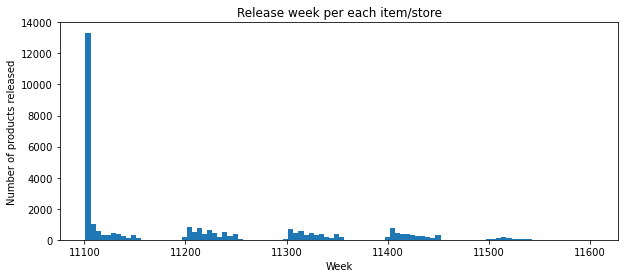

In [9]:
plt.figure(figsize=(10,4))
releases = prices.groupby(['store_id','item_id'])['wm_yr_wk'].min()
plt.hist(releases, bins=100)
plt.xlabel('Week')
plt.ylabel('Number of products released')
plt.title('Release week per each item/store')

### Calendar

Calendar contains information about 1969 days from `29-01-2011` to `19-06-2016`.

In details, there are:
- `wm_yr_wk`: week of a year;
- `weekday`, `wday`: day of the week;
- `month`, `year`: month and year
- `event_name_N`, `event_type_N`: name and category of an event;
- `snap_XX`: presence of SNAP promotion in the state `XX`;

In [10]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [11]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


#### casting of existing columns

In [12]:
calendar['date'] = calendar['date'].astype('datetime64')

calendar['wm_yr_wk'] = calendar['wm_yr_wk'].astype('int16')
calendar['month'] = calendar['month'].astype('int8')
calendar['year'] = calendar['year'].astype('int16')

# delete 'd_' prefix
calendar['d'] = calendar['d'].apply(lambda x: x[2:]).astype('int16')

calendar['snap_CA'] = calendar['snap_CA'].astype('int8')
calendar['snap_TX'] = calendar['snap_TX'].astype('int8')
calendar['snap_WI'] = calendar['snap_WI'].astype('int8')

In [13]:
calendar.describe(datetime_is_numeric=True)

date      wm_yr_wk         wday        month  \
count                 1969   1969.000000  1969.000000  1969.000000   
mean   2013-10-09 00:00:00  11347.086338     3.997461     6.325546   
min    2011-01-29 00:00:00  11101.000000     1.000000     1.000000   
25%    2012-06-04 00:00:00  11219.000000     2.000000     3.000000   
50%    2013-10-09 00:00:00  11337.000000     4.000000     6.000000   
75%    2015-02-13 00:00:00  11502.000000     6.000000     9.000000   
max    2016-06-19 00:00:00  11621.000000     7.000000    12.000000   
std                    NaN    155.277043     2.001141     3.416864   

              year            d      snap_CA      snap_TX      snap_WI  
count  1969.000000  1969.000000  1969.000000  1969.000000  1969.000000  
mean   2013.288471   985.000000     0.330117     0.330117     0.330117  
min    2011.000000     1.000000     0.000000     0.000000     0.000000  
25%    2012.000000   493.000000     0.000000     0.000000     0.000000  
50%    2013.000000   985.000000     0.000000     0.000000     0.000000  
75%    2015.000000  1477.000000     1.000000     1.000000     1.000000  
max    2016.000000  1969.000000     1.000000     1.000000     1.000000  
std       1.580198   568.545659     0.470374     0.470374     0.470374

#### Events
Some day have more than one event. Since these days are only 5, `event_name_2` and `event_type_2` are removed

In [14]:
calendar[calendar.columns[7:11]].describe()

event_name_1 event_type_1  event_name_2 event_type_2
count           162          162             5            5
unique           30            4             4            2
top       SuperBowl    Religious  Father's day     Cultural
freq              6           55             2            4

In [15]:
calendar.drop(columns=['event_name_2', 'event_type_2'], inplace=True)

In [16]:
# fill empty event records
calendar['event_name_1'].fillna('no_event', inplace=True)
calendar['event_type_1'].fillna('no_event', inplace=True)

calendar['event_name_1'] = calendar['event_name_1'].astype('category')#.astype('int8')
calendar['event_type_1'] = calendar['event_type_1'].astype('category')#.astype('int8')

#### new columns

In [17]:
# day of the week, from 0 (monday) to 6 (sunday)
calendar.insert(3, 'dayofweek', calendar['date'].dt.dayofweek.astype('int8'))
# day of the month, 1-31
calendar.insert(4, 'dayofmonth', calendar['date'].dt.day.astype('int8')) 
# day of the year, 1-366
calendar.insert(5, 'dayofyear', calendar['date'].dt.dayofyear.astype('int16'))
# week in the month, 1-5
calendar.insert(2, 'weekofmonth',calendar['dayofmonth'].apply(lambda x: (x - 1) // 7 + 1).astype('int8'))
# week in the year, 1-53
calendar.insert(3, 'weekofyear', (calendar['wm_yr_wk'] % 100).astype('int8'))

In [18]:
# align non-bisestile year to bisestile year
idx = calendar[(calendar['year'].isin([2011,2013,2014,2015])) & (calendar['dayofyear']>31+28)].index
calendar.loc[idx, 'dayofyear'] +=1

In [19]:
# check no missing values in the 'date' column
(calendar['date'][1:].reset_index(drop=True) - calendar['date'][:-1]).value_counts()

1 days    1968
Name: date, dtype: int64

In [20]:
print('date min:', calendar['date'].min().date())
print('date max:', calendar['date'].max().date())

date min: 2011-01-29
date max: 2016-06-19


In [21]:
calendar.drop(columns=['weekday', 'wday', 'date'], inplace=True)
calendar.set_index('d', inplace=True)

In [22]:
calendar

wm_yr_wk  weekofmonth  weekofyear  dayofweek  dayofmonth  dayofyear  \
d                                                                           
1        11101            5           1          5          29         29   
2        11101            5           1          6          30         30   
3        11101            5           1          0          31         31   
4        11101            1           1          1           1         32   
5        11101            1           1          2           2         33   
...        ...          ...         ...        ...         ...        ...   
1965     11620            3          20          2          15        167   
1966     11620            3          20          3          16        168   
1967     11620            3          20          4          17        169   
1968     11621            3          21          5          18        170   
1969     11621            3          21          6          19        171   

      month  year  event_name_1 event_type_1  snap_CA  snap_TX  snap_WI  
d                                                                        
1         1  2011      no_event     no_event        0        0        0  
2         1  2011      no_event     no_event        0        0        0  
3         1  2011      no_event     no_event        0        0        0  
4         2  2011      no_event     no_event        1        1        0  
5         2  2011      no_event     no_event        1        0        1  
...     ...   ...           ...          ...      ...      ...      ...  
1965      6  2016      no_event     no_event        0        1        1  
1966      6  2016      no_event     no_event        0        0        0  
1967      6  2016      no_event     no_event        0        0        0  
1968      6  2016      no_event     no_event        0        0        0  
1969      6  2016  NBAFinalsEnd     Sporting        0        0        0  

[1969 rows x 13 columns]

### Sales

In the directory there are two datasets: 
- `sales_train_validation`: historical daily unit sales per product and store in $[d_1; d_{1913}]$, in which the last 28 days contain:
    - the **input** for the **public** leaderboard;
- `sales_train_evaluation`: historical daily unit sales per product and store in $[d_1; d_{1941}]$, in which the last 28 days contain both:
    - the **label** for the **public** leaderboard and 
    - the **input** for the **private** leaderboard.

In the following, only the last dataframe is used. 

In [23]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [24]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [25]:
# rename day columns by deleting 'd_'
sales.rename(columns={x: x[2:] for x in sales.columns[6:]}, inplace=True)

# casting
cols = sales.columns.tolist()
sales_1 = sales[cols[:6]].astype('category')
sales_2 = sales[cols[6:]].astype('int16')
sales = pd.concat([sales_1, sales_2], axis=1)

# delete 'evaluation' suffix 
sales['id'] = sales['id'].apply(lambda x: x[:-11])

del sales_1, sales_2, cols

In [26]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to 1941
dtypes: category(6), int16(1941)
memory usage: 114.4 MB


### Write on disk

In [27]:
dst = '../processed/'

if not os.path.exists(dst):
        os.makedirs(dst)
        
# save data
prices.to_parquet(dst + '/m5_prices.pqt')
calendar.to_parquet(dst + '/m5_calendar.pqt')
sales.to_parquet(dst + '/m5_sales.pqt')    

## 2) Data exploration

In [28]:
calendar, prices, sales = utils.read_data_pqt()

In [29]:
%%time
df = preprocessing.remove_leading_zeros(sales, calendar)

CPU times: total: 37.2 s
Wall time: 37.4 s


### Unit sales per state, store, category and departments

It is possible to notice that the unit sales are **not** uniformly distributed among states, store, category and departments. 
- Sales in `CA` represent more than 40% of the total. 
- In California there is both the store with the highest amount of sales (`CA_3`) and the store with the lowest amount (`CA_1`).
- About 70% of the total sales comes from `FOODS` products, of which `FOODS_3` represents the major part.

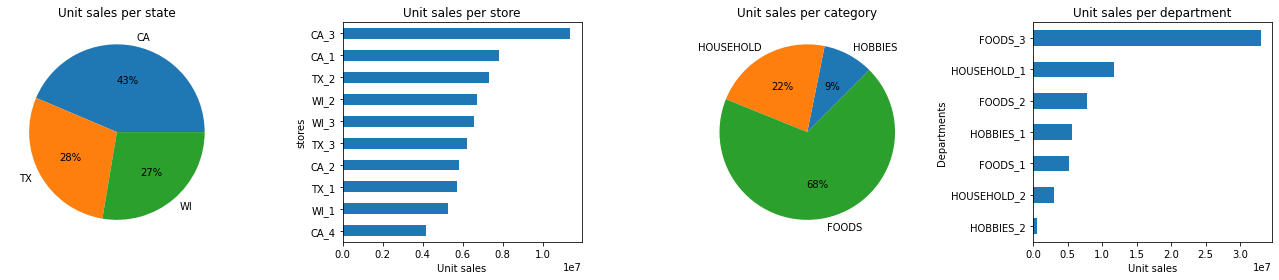

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(18, 4))

# flatten
#ax = [cell for row in ax for cell in row]

df.groupby('state_id')['sales'].sum().plot.pie(ax=ax[0], autopct='%d%%')
ax[0].set_title('Unit sales per state')
ax[0].set_ylabel('')

df.groupby('store_id')['sales'].sum().sort_values().plot.barh(ax=ax[1]) #barh(figsize=(6,4))
ax[1].set_title('Unit sales per store')
ax[1].set_ylabel('stores')
ax[1].set_xlabel('Unit sales')

df.groupby('cat_id')['sales'].sum().sort_values().plot.pie(ax=ax[2], startangle=45, autopct='%d%%')
ax[2].set_title('Unit sales per category')
ax[2].set_ylabel('')

df.groupby('dept_id')['sales'].sum().sort_values().plot.barh(ax=ax[3])
ax[3].set_xlabel('Unit sales')
ax[3].set_ylabel('Departments')
ax[3].set_title('Unit sales per department')

fig.tight_layout()

Text(0, 0.5, 'Unit sales')

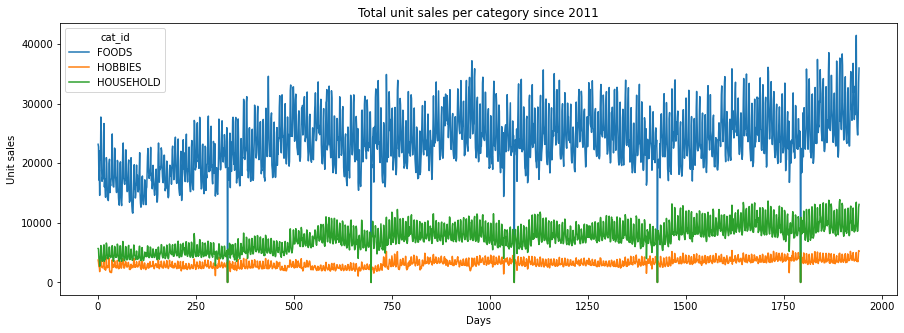

In [31]:
df.groupby(['d', 'cat_id'])['sales'].sum().unstack().plot(figsize=(15,5))
plt.title('Total unit sales per category since 2011')
plt.xlabel('Days')
plt.ylabel('Unit sales')

Text(0.5, 0.95, 'Average unit sales per category and department')

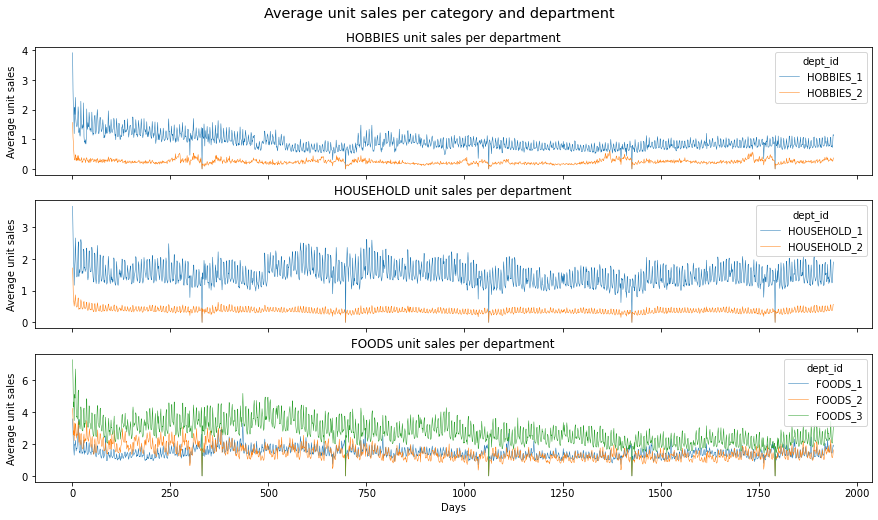

In [32]:
categories = df['cat_id'].unique()
fig, ax = plt.subplots(len(categories), 1, sharex=True, figsize=(15,8))

for i, c in enumerate(categories):
    df[df['cat_id']==c].groupby(['d', 'dept_id'], observed=True)['sales'].mean().unstack().plot(linewidth=0.5, ax=ax[i])
    
    ax[i].set_title(f'{c} unit sales per department')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Average unit sales') 

    
plt.suptitle('Average unit sales per category and department', y=0.95, fontsize='x-large')

### Similarities across stores, departments

There are similarities both:
- in each **department**, across different states/stores, meaning that similar products behave in a similar manner,
- and in each **store**, across products belonging to different departments, meaning that there are local pattern.  

In [33]:
%%capture

idx = np.arange(D_PUBLIC - 60, D_PRIVATE).tolist()

# minor ticks every monday
minor_ticks = calendar.loc[idx][calendar['dayofweek'] == 0].index.tolist()
# major ticks every first day of month
major_ticks = calendar.loc[idx][calendar['dayofmonth'] == 1].index.tolist()

Text(0.5, 0.9, 'Unit sales per store (across different departments)')

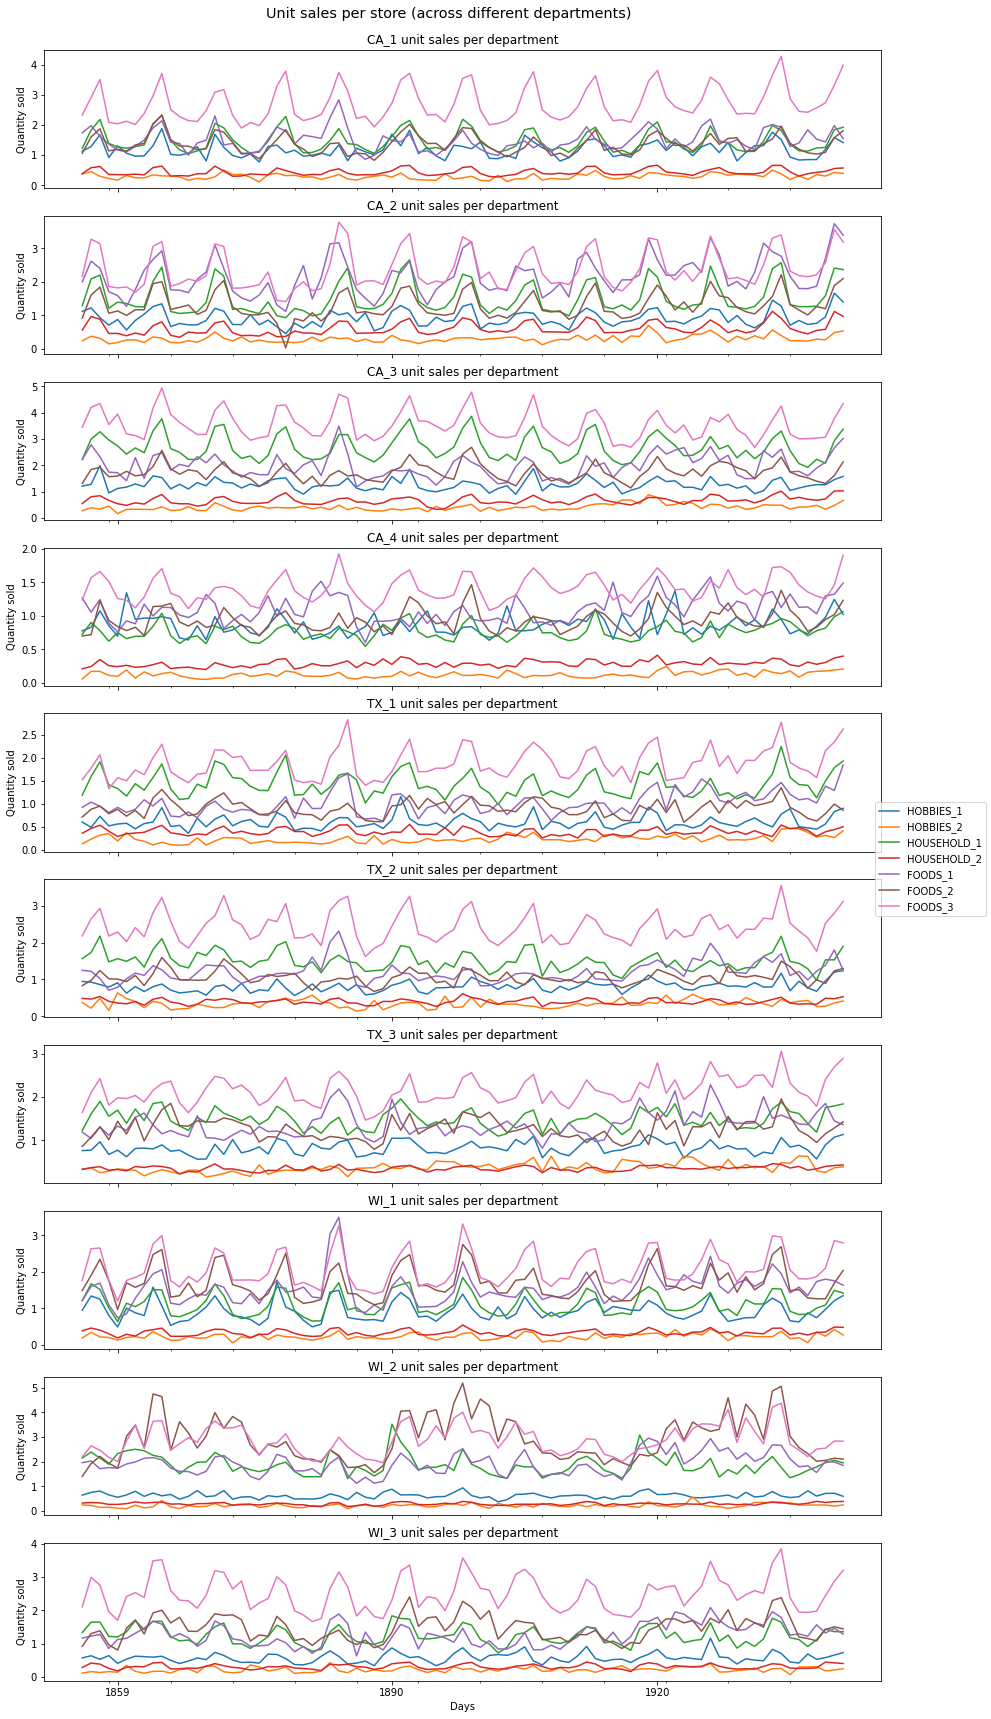

In [34]:
stores = df['store_id'].unique()
fig, ax = plt.subplots(10, 1, sharex=True, sharey=False, figsize=(15, 30))

for i, s in enumerate(stores):
    df[(df['store_id'] == s) & (df['d'] > D_PUBLIC-60)].groupby(['d', 'dept_id'], observed=True)['sales'].mean().unstack().plot(ax=ax[i])
    
    ax[i].get_legend().remove()
    ax[i].set_title(f'{s} unit sales per department')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Quantity sold')
    ax[i].set_xticks(minor_ticks, minor=True)
    ax[i].set_xticks(major_ticks, minor=False)

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
plt.suptitle('Unit sales per store (across different departments)', y=0.9, fontsize='x-large')    

Text(0.5, 0.92, 'Unit sales per department (across different stores)')

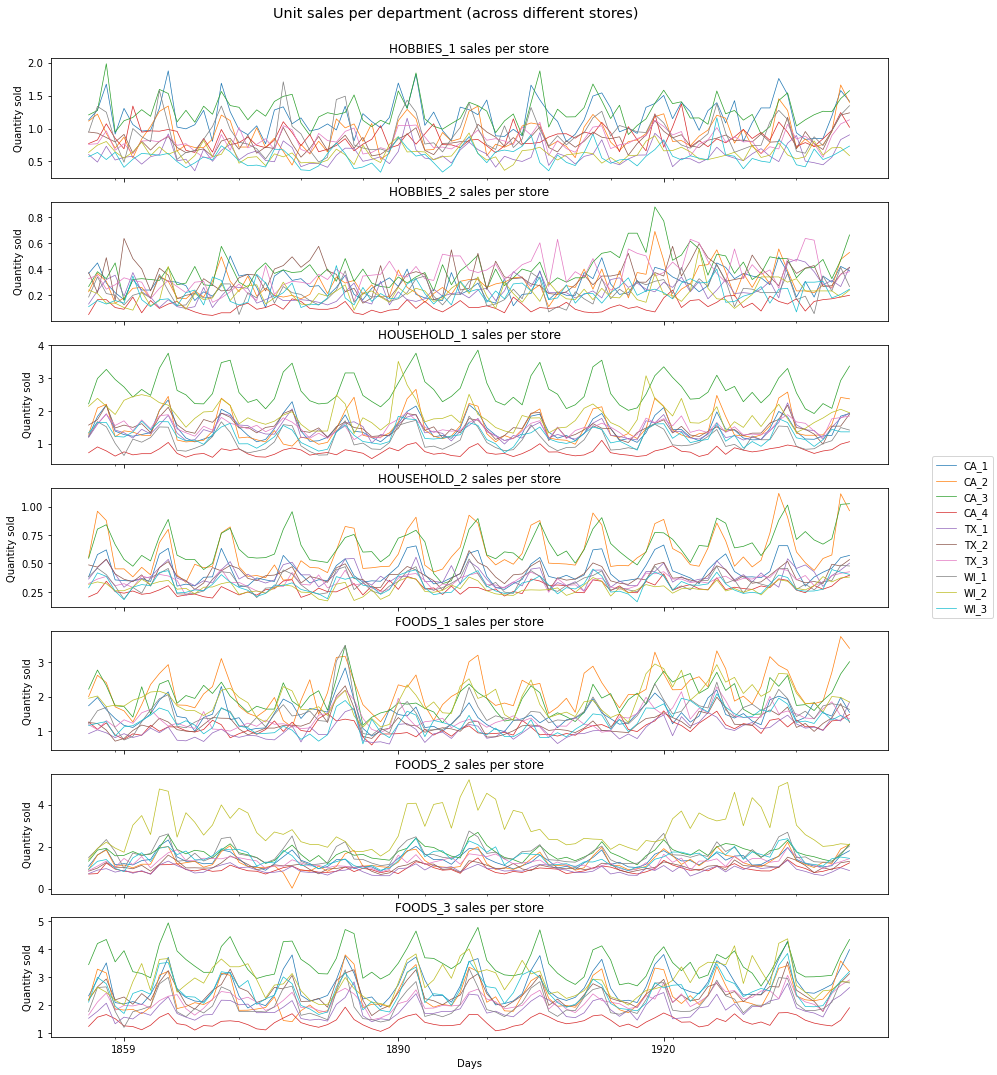

In [35]:
departments = df['dept_id'].unique()

fig, ax = plt.subplots(len(departments), sharex=True, sharey=False, figsize=(15, 18))

for i, d in enumerate(departments):
    df[(df['dept_id'] == d) & (df['d'] > D_PUBLIC-60)].groupby(['d', 'store_id'])['sales'].mean().unstack()\
        .plot(linewidth=0.7, ax=ax[i])
    
    ax[i].get_legend().remove()
    ax[i].set_title(f'{d} sales per store')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Quantity sold') 
    ax[i].set_xticks(minor_ticks, minor=True)
    ax[i].set_xticks(major_ticks, minor=False)

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

plt.suptitle('Unit sales per department (across different stores)', y=0.92, fontsize='x-large')

### Categories across stores

By looking at whole timeseries (since 2011) per each store, it is possible to notice:
- some seasonal patterns (that will be covered in the next sessions)
- some periods which differ a lot from the general behaviour of the timeseries. These periods will be removed.

Text(0.5, 0.9, 'Store unit sales per category, category')

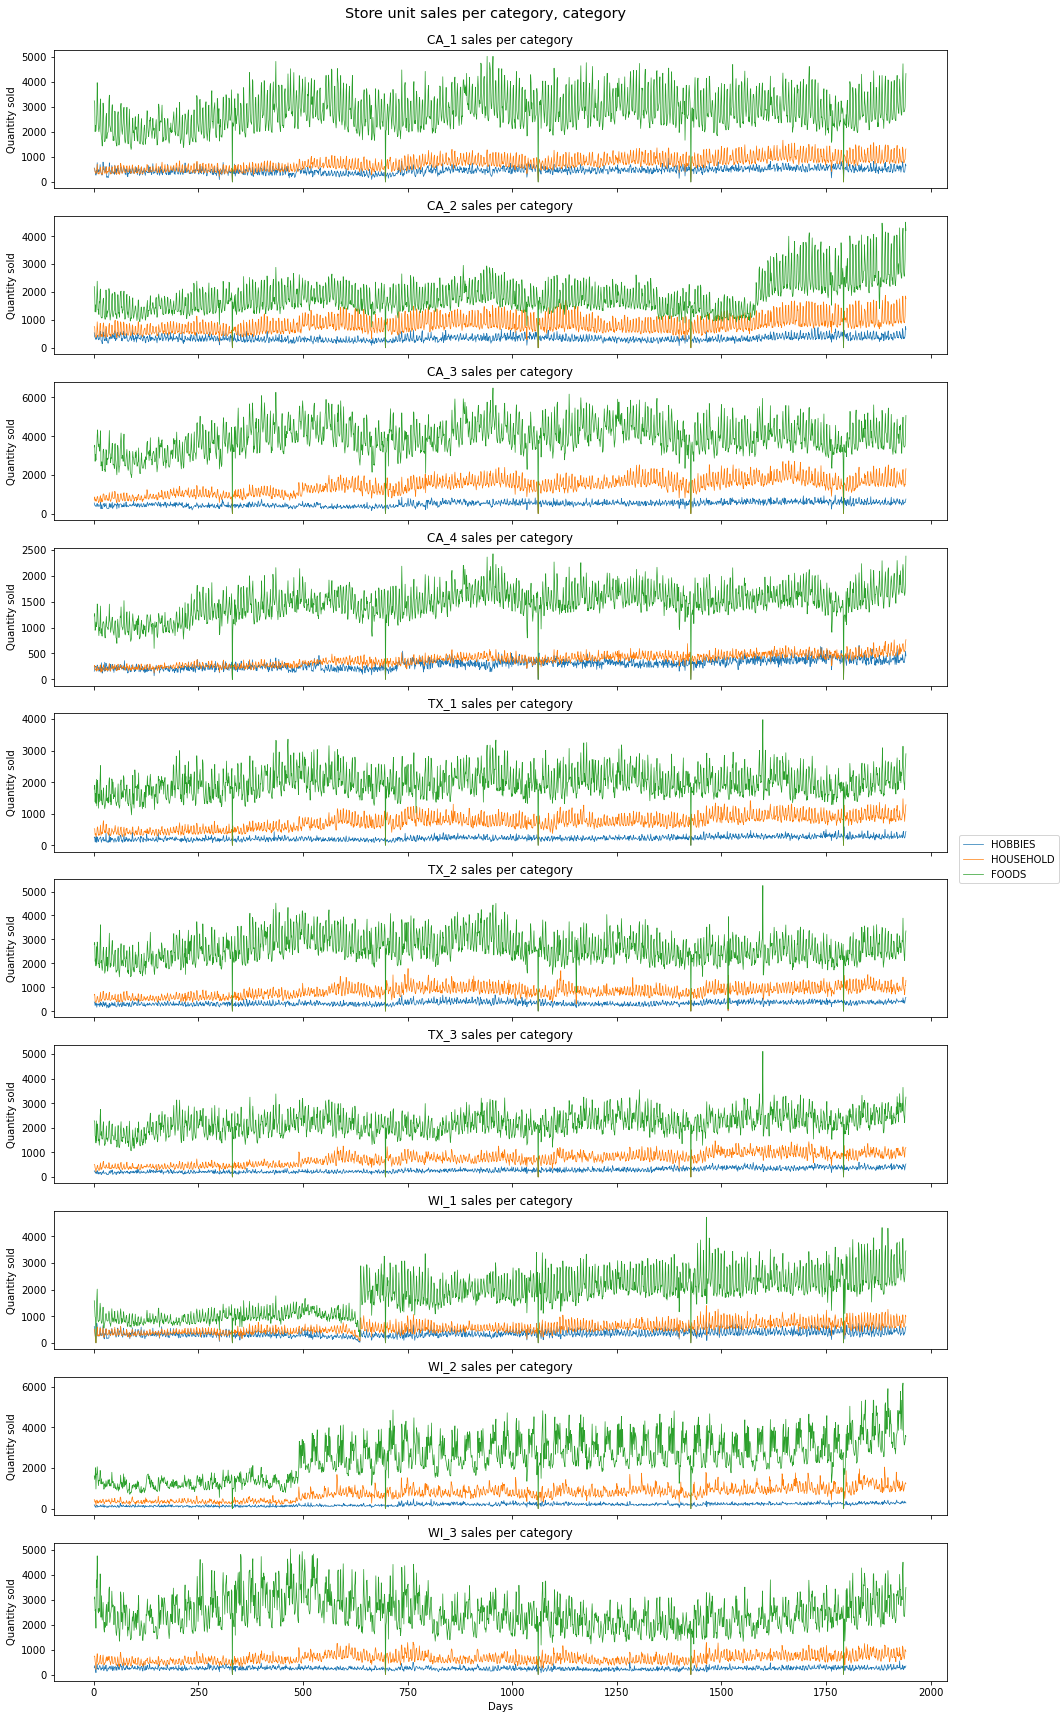

In [36]:
fig, ax = plt.subplots(10, 1, sharex=True, figsize=(16,30))


for i, s in enumerate(df['store_id'].unique()):
    df[df['store_id']==s].groupby(['d', 'cat_id'], observed=True)['sales'].sum().unstack().plot(linewidth=0.7, ax=ax[i])
    
    ax[i].get_legend().remove()
    ax[i].set_title(f'{s} sales per category')
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Quantity sold') 

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')    

plt.suptitle('Store unit sales per category, category', y=0.9, fontsize='x-large')

#### Detail
- Sales in **WI_1** are sensibily lower before day 637, and they drop down near that date
- Sales in **WI_2** are sensibly lower before day 490, and it looks like they do not show the seasonal pattern present in the successive years

Text(0.5, 1.0, 'Unit sales in WI_2')

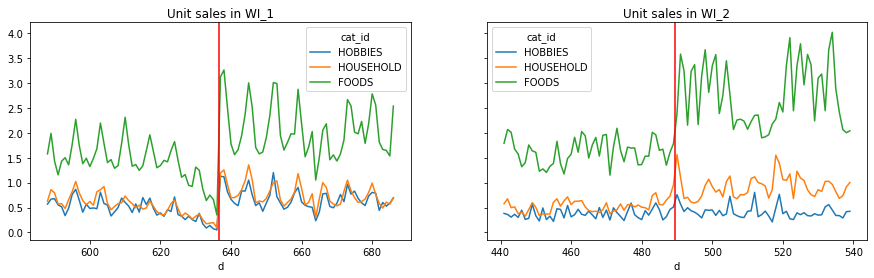

In [37]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15, 4))

d = 637
df[(df['store_id']=='WI_1') & (df['d']>d-50) & (df['d']<d+50)] \
    .groupby(['d', 'cat_id'], observed=True)['sales'].mean().unstack().plot(ax=ax[0])
ax[0].axvline(d-0.5, 0, 1, color='red')
ax[0].set_title('Unit sales in WI_1')

d = 490
df[(df['store_id']=='WI_2') & (df['d']>d-50) & (df['d']<d+50)] \
    .groupby(['d', 'cat_id'], observed=True)['sales'].mean().unstack().plot(ax=ax[1])
ax[1].axvline(d-0.5, 0, 1, color='red')
ax[1].set_title('Unit sales in WI_2')

### Seasonality

#### Year, Month 


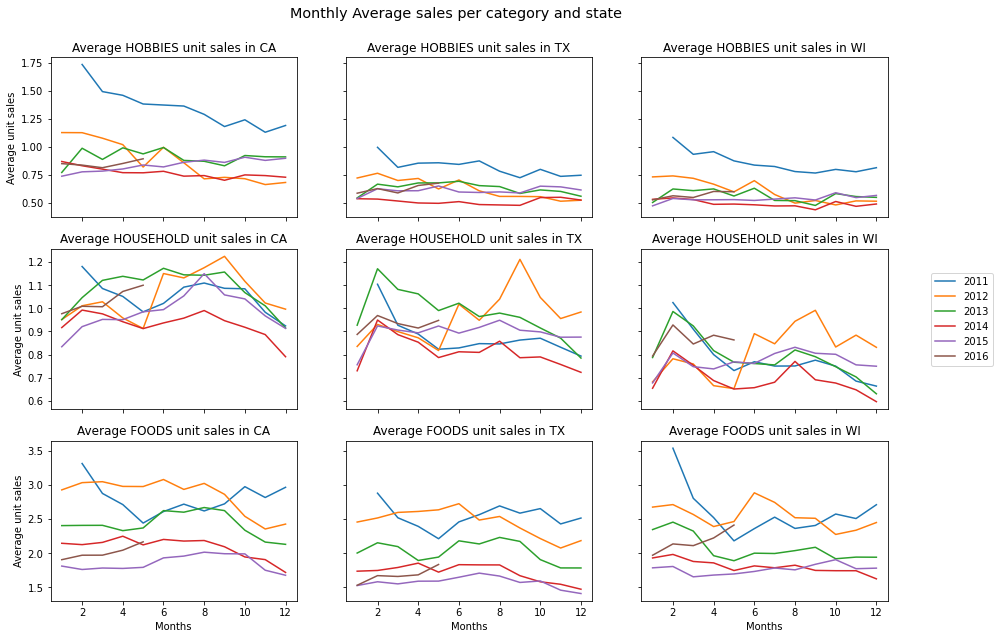

In [38]:
categories = df['cat_id'].unique()
states = df['state_id'].unique()

fig, ax = plt.subplots(len(categories), len(states), sharex=True, sharey='row', figsize=(15, 10))
ax = [cell for row in ax for cell in row]

for i, c in enumerate(categories):
    data = df[(df['cat_id']==c) & (df['d']>3)]
    for j, s in enumerate(states):
        k = 3*i+j
        data[data['state_id']==s].groupby(['month', 'year'], observed=True)['sales'].mean().unstack().plot(ax=ax[k])
        ax[k].get_legend().remove()    
        ax[k].set_title(f'Average {c} unit sales in {s}')
        ax[k].set_xlabel('Months')
        ax[k].set_ylabel('Average unit sales')   

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

plt.suptitle('Monthly Average sales per category and state', y=0.95, fontsize='x-large')  

del data

#### Day of month

- `FOODS_2`, `FOODS_3` products are generally higher in the first half of the month. 
    - This situation is enhanced in `WI_2`, `WI_3`, where there is an evident pattern.
- The day of month seems almost irrilevant for `HOBBIES` and `HOUSEHOLD` products.




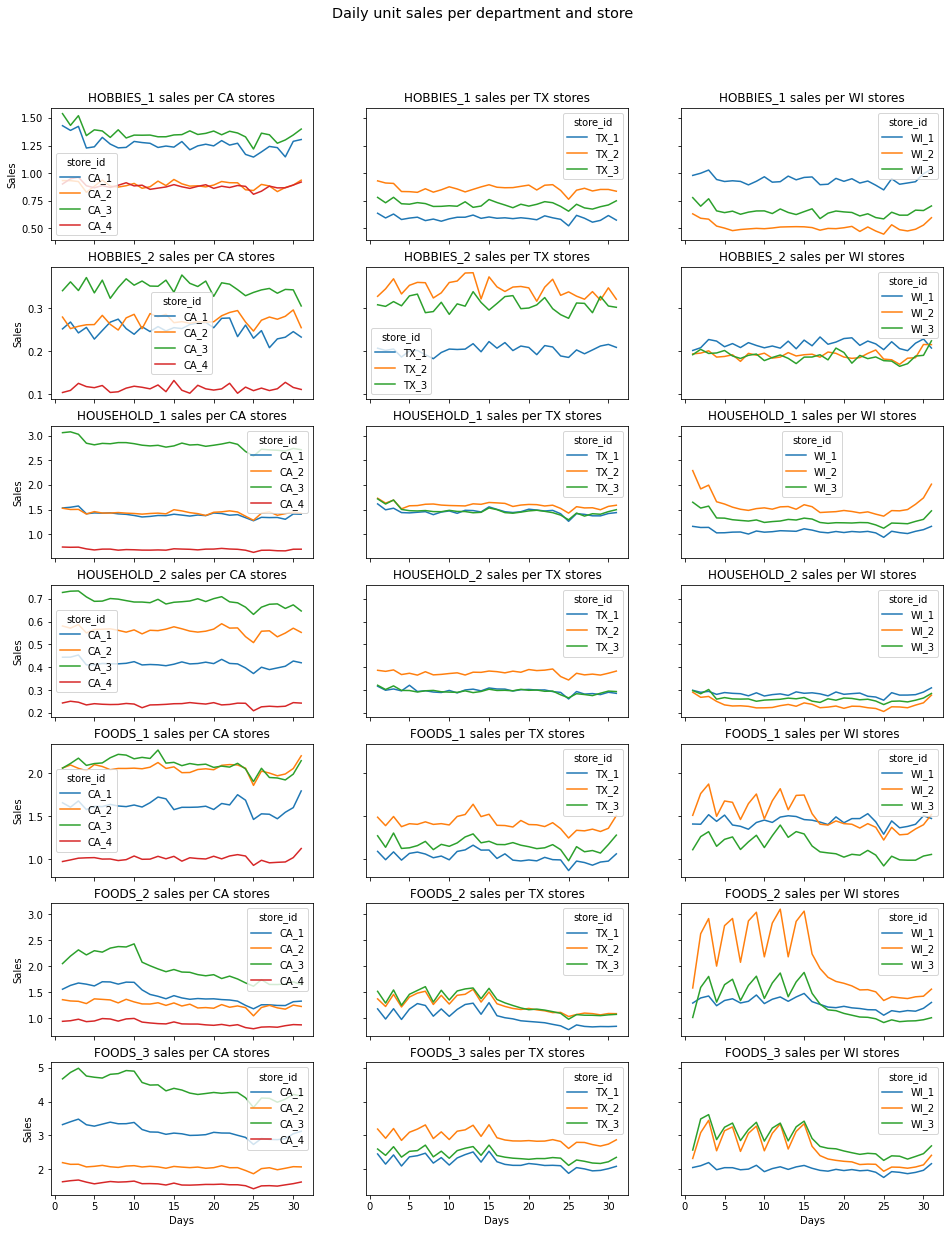

In [39]:
departments = df['dept_id'].unique()
states = df['state_id'].unique()

fig, ax = plt.subplots(len(departments), len(states), sharex=True, sharey='row', figsize=(16,20))

for i, d in enumerate(departments):
    data = df[df['dept_id']==d]
    for j, s in enumerate(states):
        data[data['state_id']==s].groupby(['dayofmonth', 'store_id'], observed=True)['sales'].mean().unstack().plot(ax=ax[i][j])
    
        ax[i][j].set_title(f'{d} sales per {s} stores')
        ax[i][j].set_xlabel('Days')
        ax[i][j].set_ylabel('Sales')   

plt.suptitle('Daily unit sales per department and store', y=0.95, fontsize='x-large')

del data    

#### Day of week
All departments and stores have higher sales in the weekends

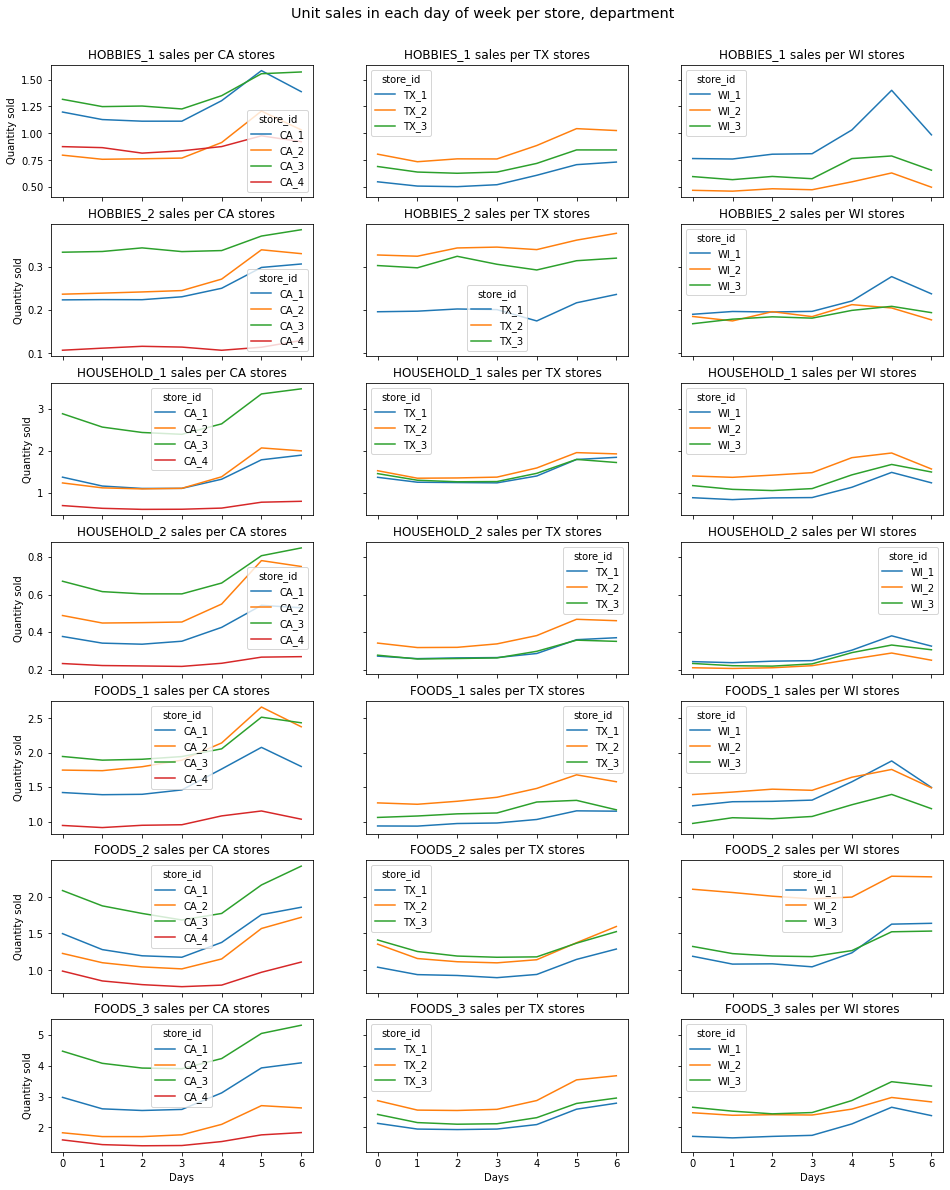

In [40]:
departments = df['dept_id'].unique()
states = df['state_id'].unique()

fig, ax = plt.subplots(len(departments), len(states), sharex=True, sharey='row', figsize=(16,20))

for i, d in enumerate(departments):
    data = df[df['dept_id']==d]
    for j, s in enumerate(states):
        data[data['state_id']==s].groupby(['dayofweek', 'store_id'], observed=True)['sales'].mean().unstack().plot(ax=ax[i][j])
    
        ax[i][j].set_title(f'{d} sales per {s} stores')
        ax[i][j].set_xlabel('Days')
        ax[i][j].set_ylabel('Quantity sold')   

plt.suptitle('Unit sales in each day of week per store, department', y=0.92, fontsize='x-large')

del data    

#### SNAP days
- Average unit sales are usually slightly higher on SNAP days, especially for `FOODS` products. 
- `WI` is the state that benefits more from SNAP promotions.

Text(0.5, 0.98, 'Average units sales on SNAP days')

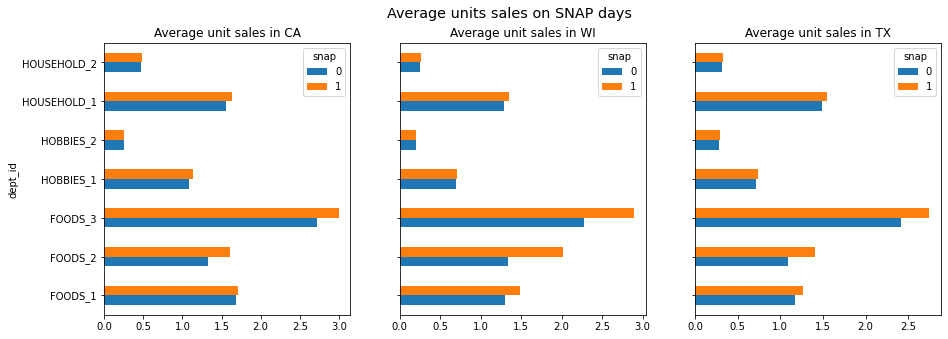

In [41]:
states = ['CA', 'WI', 'TX']
fig, ax = plt.subplots(1, len(states), figsize=(15, 5), sharey=True)

for i, s in enumerate(states):
    df[df['state_id']==s].groupby(['dept_id', 'snap'])['sales'].mean().unstack().plot.barh(ax=ax[i])
    ax[i].set_title(f'Average unit sales in {s}')

plt.suptitle('Average units sales on SNAP days', fontsize='x-large')

#### Event days
The presence of an event influences the sales. The red line shows the average unit sales on no-event days. 

The behaviour is slightly different across the states, but it is possible to outline that:
- in some occasions such as `SuperBowl`, `OrthodoxEaster` and `LaborDay` sales are higher than the average
- On other days, such as `Thanksgiving` or `NewYear`, sales are lower, instead. 
- On `Christmas` sales are zero since stores are closed.



Text(0.5, 0.95, 'Average unit sales on event days')

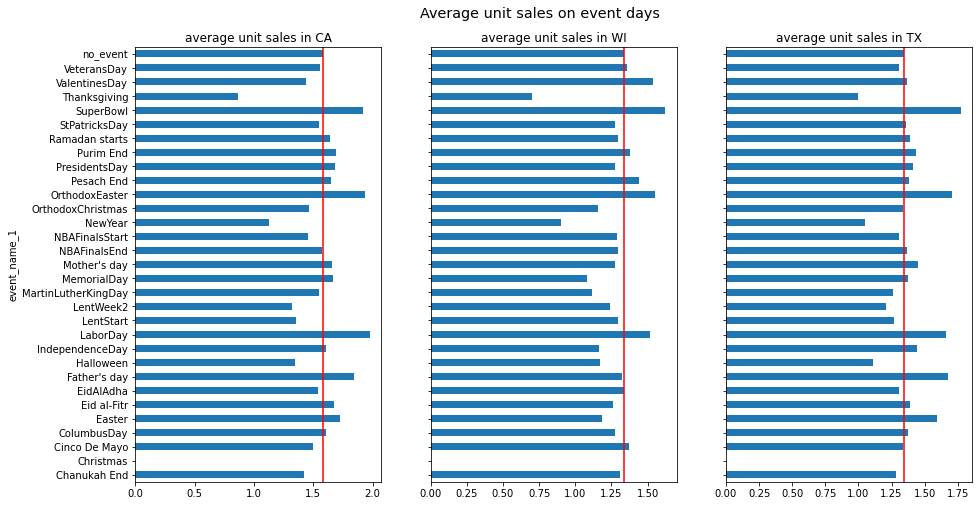

In [42]:
states = ['CA', 'WI', 'TX']
fig, ax = plt.subplots(1, len(states), figsize=(15, 8), sharey=True)

for i, s in enumerate(states):
    tmp = df[df['state_id']==s].groupby('event_name_1')['sales'].mean()
    tmp.plot.barh(ax=ax[i])
    ax[i].axvline(tmp['no_event'], color='red')
    ax[i].set_title(f'average unit sales in {s}')

plt.suptitle('Average unit sales on event days', y=0.95, fontsize='x-large')
del tmp

### Autocorrelation

Autocorrelation is computed in order to find possible lag values that may be useful in making predictions.

For most of departments/stores, lag 7 (and its multiples) are the most relevant, but there are few exceptions:
- no/little correlation: 
    - `FOODS_1` in `WI_2`, `CA_4`; 
    - `HOBBIES_1` in `WI_2`, `CA_4`; 
    - `HOBBIES_2` (all stores);  
    - `HOUSEHOLD_2` in `WI_2`, `CA_4`, 
- lag 28 or 30 more relevant than lag 7: 
    - `FOODS_2` in `CA_3`, `TX_1`, `TX_3`, `WI_2`, `WI_3`;
    - `FOODS_3` in  `WI_2`.


In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [44]:
# average sales of product in the same department and store in different days
df2 = df.groupby(['dept_id', 'store_id', 'd'], as_index=False)['sales'].mean()

In [45]:
df2.head()

dept_id store_id  d     sales
0  FOODS_1     CA_1  1  4.242857
1  FOODS_1     CA_1  2  3.302326
2  FOODS_1     CA_1  3  2.431818
3  FOODS_1     CA_1  4  1.923077
4  FOODS_1     CA_1  5  1.936170

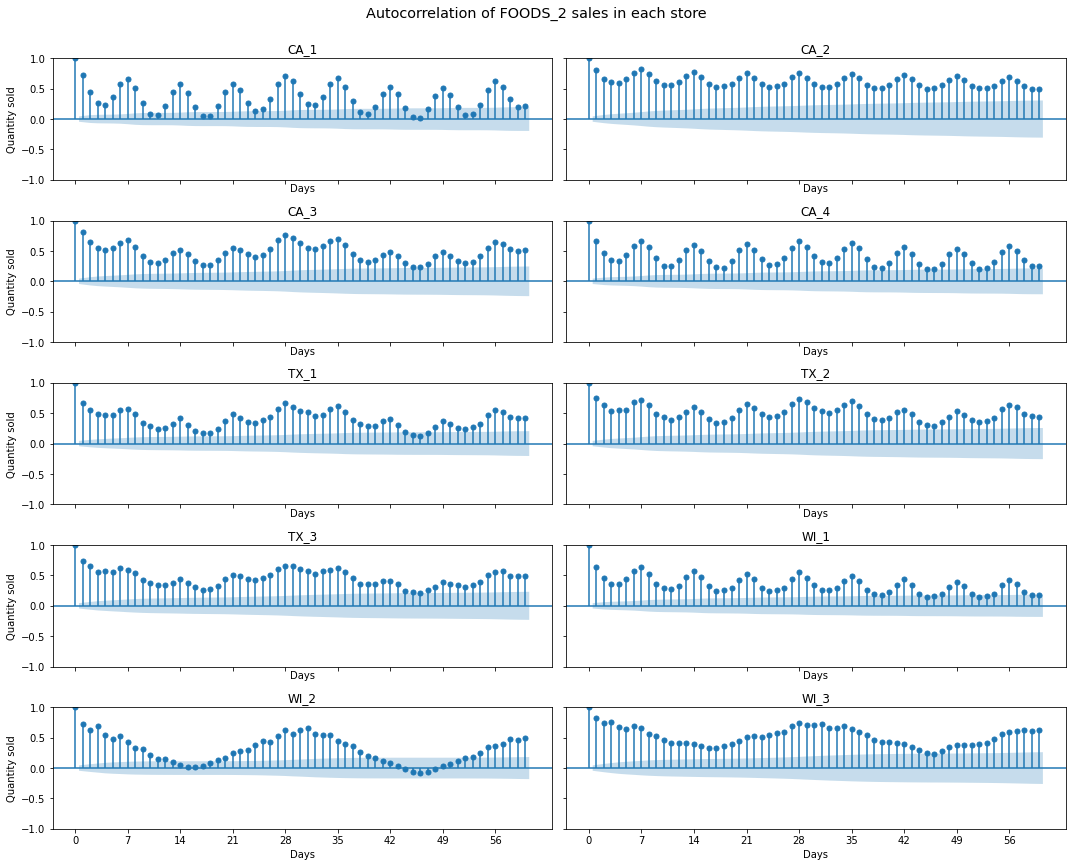

In [46]:
departments = df2['dept_id'].unique()
stores = df2['store_id'].unique()
lags = 60

fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(15, 12))

ax = [cell for row in ax for cell in row]

cur_dept = departments[1] # change to select another department

data = df2[df2['dept_id']==cur_dept]    

for i, s in enumerate(stores):
    plot_acf(data[data['store_id']==s]['sales'], ax=ax[i], lags=lags)
    
    ax[i].set_title(f'{s}')
    ax[i].set_xlabel('Days')
    if not(i % 2):
        ax[i].set_ylabel('Quantity sold')   
    ax[i].set_xticks(np.arange(0, lags, 7))

plt.suptitle(f'Autocorrelation of {cur_dept} sales in each store', y=1, fontsize='x-large')
plt.tight_layout()
del data  

## 3) Feature engineering

In [47]:
if 'df' in globals():
    del df
    
if 'df2' in globals():
    del df2    

In [49]:
calendar, prices, sales = utils.read_data_pqt()

prices['sell_price'] = prices['sell_price'].astype('float16')

In [52]:
from importlib import reload
reload(fe)

<module 'm5_fe' from 'C:\\Users\\userl\\Documents\\GitHub\\vece-m5-forecasting-accuracy\\data\\code\\m5_fe.py'>

In [55]:
%%time 

# change to select another state
cur_state = 'WI' #'CA', 'TX', 'WI'

df = sales[(sales['state_id']==cur_state)]
df.reset_index(drop=True, inplace=True)

df = preprocessing.add_days(df)
df = preprocessing.remove_leading_zeros(df, calendar)

if cur_state == 'WI':
    df = df[(df['store_id']!='WI_1') | (df['d']>636)]
    df = df[(df['store_id']!='WI_2') | (df['d']>489)]
    df.reset_index(inplace=True, drop=True)

fe.compute_and_save_products(df, cur_state)
fe.compute_and_save_prices(df, prices, cur_state)
fe.compute_and_save_sales(df)

Saving products...
Computing prices...
Computing sales...
CPU times: total: 3min 25s
Wall time: 3min 25s


### calendar

* Add calendar features to dataframe

* For each `id`, namely each pair `(product, store)`, the date of the **first sale** is computed and data before that date are removed

### SNAP columns
For each record, only the snap value that refers to its state is kept

### Feature engineering (1)
Feature related to prices are computed. 

*Assumption: future prices are known.*

For each `id`, we compute:
* `price_last_week`: ratio between the **current price** and its price the **week before**
* `price_next_week`: ratio between the **current price** and its price the **next week**
* `price_curr_month`: ratio between the **current price** and its average price in the **current month**
* `price_same_dept`: ratio between the **current price** and the average price of the **similar products** (=that belong to the same department) in the same week

### Feature engineering (2):
Features related to the target are computed. 

**Non-recursive** features are computed on data that do not belong to the last 28 days.

In detail, for each id the following is considered:
* `sales_year`: average sales in the **previous year**;
* `sales_month`: average sales in the **same month** of the **previous year**;
* `sales_week`: average sales in the **same week** of the **previous year**;
* `sales_dayofmonth`: average sales in the **same day of month** of the **previous year**;
* `sales_dayofweek`: average sales in the **same day of week** in the last weeks. To ensure no leakage, we consider periods weeks from 5 to 16
* `sales_rolling_mean_28_28`: sales rolling mean of $28$ days, starting from $28$ days before.

**Recursive** features are computed on data that include the last 28 days. 

As a consequence:
* during the training, **ground truth** is used in the computation
* during the testing, instead, **predictions** are used as input to compute such features.

In detail, for each id the following is considered:
* `sales_dayofweek`: average sales in the last $6$ weeks;
* `sales_rolling_mean_7_28`, `sales_rolling_mean_7_42`: rolling mean of length $28$ and $42$, starting from $7$ days before.

Finally, standard deviation of the sales is computed.

#### non recursive

In [ ]:
D_MAX = df['d'].max()
D_MIN = df['d'].min()
D_PRIVATE = D_MAX - 28 + 1 # 1914 - 1941

print(f'Training range:\t {D_MIN} - {D_EVAL - 1}')
print(f'Evaluation range: {D_EVAL} - {D_MAX}')

### Feature engineering (3):
Event labels are sorted according to the average sales in each event day.

## 4) Model Implementation

In [57]:
if 'prices' in globals():
    del prices
if 'calendar' in globals():
    del calendar
if 'sales' in globals():
    del sales
if 'df' in globals():
    del df    

In [377]:
cur_store = 'WI_3' # change to select a different store

In [378]:
df = utils.load_df(cur_store)

In [379]:
df.drop(columns=['store_id', 'state_id', 'wm_yr_wk'], inplace=True)

### Correlation

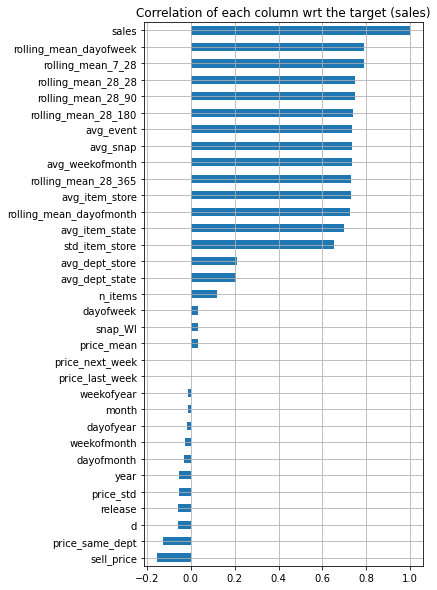

In [380]:
corr = df.corrwith(df['sales']).sort_values()
corr.plot.barh(figsize=(5, 10))
plt.grid(True)
plt.title('Correlation of each column wrt the target (sales)')

del corr

In [381]:
df.head()

id    d  sales  rolling_mean_dayofweek  rolling_mean_7_28  \
0  HOBBIES_1_002_WI_3  338    0.0                1.000000           1.500000   
1  HOBBIES_1_004_WI_3  338    0.0                2.333984           2.535156   
2  HOBBIES_1_005_WI_3  338    2.0                1.666992           2.892578   
3  HOBBIES_1_008_WI_3  338    0.0                3.500000           4.355469   
4  HOBBIES_1_009_WI_3  338    2.0                1.666992           1.428711   

   rolling_mean_28_28  rolling_mean_28_90  rolling_mean_28_180  \
0            0.678711            0.522461             0.438965   
1            2.357422            2.054688             2.650391   
2            2.322266            2.166016             1.622070   
3            5.035156            3.677734             3.449219   
4            1.142578            0.955566             1.455078   

   rolling_mean_28_365  rolling_mean_dayofmonth  ...  year  event_name_1  \
0             0.302490                     1.00  ...  2012       NewYear   
1             3.361328                     4.25  ...  2012       NewYear   
2             1.557617                     4.00  ...  2012       NewYear   
3             3.361328                     5.75  ...  2012       NewYear   
4             1.448242                     2.25  ...  2012       NewYear   

   event_type_1  snap_WI  sell_price  price_last_week  price_next_week  \
0      National        0    3.970703              0.0              0.0   
1      National        0    4.339844              0.0              0.0   
2      National        0    2.480469              0.0              0.0   
3      National        0    0.500000              0.0              0.0   
4      National        0    1.639648              0.0              0.0   

   price_same_dept  price_mean price_std  
0         0.766113    0.000000  0.000000  
1         0.837402    0.041504  0.146484  
2         0.478516    0.155762  0.154541  
3         0.096436   -0.050781  0.020050  
4         0.316406    0.046875  0.066284  

[5 rows x 39 columns]

In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312966 entries, 0 to 4312965
Data columns (total 39 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   id                       category
 1   d                        int16   
 2   sales                    float16 
 3   rolling_mean_dayofweek   float16 
 4   rolling_mean_7_28        float16 
 5   rolling_mean_28_28       float16 
 6   rolling_mean_28_90       float16 
 7   rolling_mean_28_180      float16 
 8   rolling_mean_28_365      float16 
 9   rolling_mean_dayofmonth  float16 
 10  avg_item_store           float16 
 11  std_item_store           float16 
 12  avg_item_state           float16 
 13  avg_dept_store           float16 
 14  avg_dept_state           float16 
 15  avg_snap                 float16 
 16  avg_event                float16 
 17  avg_weekofmonth          float16 
 18  n_items                  int16   
 19  item_id                  category
 20  dept_id                 

### corr_matrix

In [383]:
#from seaborn import heatmap

#cols = df.columns.tolist()[2:]
#corr_matrix = df[cols].corr().astype('float32')
#plt.figure(figsize=(12, 12))
#heatmap(corr_matrix, annot=False, square=True)

In [384]:
#del cols
#del corr_matrix

### models

In [385]:
x_cols = df.columns.tolist()
# label is removed
x_cols.remove('sales')

# remove id/item_id for better generalization
x_cols.remove('id')
x_cols.remove('item_id')
#x_cols.remove('cat_id') #togli
#x_cols.remove('avg_dept_store') #si ##indifferente
x_cols.remove('avg_dept_state') #indifferente
#x_cols.remove('weekofmonth') #tieni
#x_cols.remove('snap_TX') #tieni
#x_cols.remove('avg_item_state')#tieni
#x_cols.remove('price_same_dept') #tieni
#x_cols.remove('sell_price')
#x_cols.remove('dayofyear')
#x_cols.remove('d')

# insert/remove other columns (fine-tune)
#x_cols.remove('rolling_mean_dayofmonth')
##x_cols.remove('avg_dayofmonth')
##x_cols.remove('avg_month')
#############x_cols.remove('avg_year') #buona sulla cv ma non sulla oublic

#x_cols.remove('month')
x_cols.remove('year')
x_cols.remove('event_type_1')

#x_cols.remove('rolling_mean_dayofmonth')

#x_cols.remove('weekofyear') #'??
#x_cols.remove('rolling_mean_28_180')
#x_cols.remove('rolling_mean_28_365')

#x_cols.remove('avg_weekofmonth')
#x_cols.remove('std_item_store')

In [386]:
x_cols

['d',
 'rolling_mean_dayofweek',
 'rolling_mean_7_28',
 'rolling_mean_28_28',
 'rolling_mean_28_90',
 'rolling_mean_28_180',
 'rolling_mean_28_365',
 'rolling_mean_dayofmonth',
 'avg_item_store',
 'std_item_store',
 'avg_item_state',
 'avg_dept_store',
 'avg_snap',
 'avg_event',
 'avg_weekofmonth',
 'n_items',
 'dept_id',
 'cat_id',
 'release',
 'weekofmonth',
 'weekofyear',
 'dayofweek',
 'dayofmonth',
 'dayofyear',
 'month',
 'event_name_1',
 'snap_WI',
 'sell_price',
 'price_last_week',
 'price_next_week',
 'price_same_dept',
 'price_mean',
 'price_std']

#### LGBM

In [387]:
import lightgbm as lgbm
lgbm.__version__

'3.3.2'

In [388]:
len(x_cols)

33

In [389]:
x_cols

['d',
 'rolling_mean_dayofweek',
 'rolling_mean_7_28',
 'rolling_mean_28_28',
 'rolling_mean_28_90',
 'rolling_mean_28_180',
 'rolling_mean_28_365',
 'rolling_mean_dayofmonth',
 'avg_item_store',
 'std_item_store',
 'avg_item_state',
 'avg_dept_store',
 'avg_snap',
 'avg_event',
 'avg_weekofmonth',
 'n_items',
 'dept_id',
 'cat_id',
 'release',
 'weekofmonth',
 'weekofyear',
 'dayofweek',
 'dayofmonth',
 'dayofyear',
 'month',
 'event_name_1',
 'snap_WI',
 'sell_price',
 'price_last_week',
 'price_next_week',
 'price_same_dept',
 'price_mean',
 'price_std']

In [390]:
mask_valid = (df['d']>=D_PUBLIC) & (df['d']<D_PRIVATE)
mask_eval = df['d']>=D_PRIVATE

# public data
x_valid = df[mask_valid][x_cols]
y_valid = df[mask_valid]['sales']

# private data
x_eval = df[mask_eval][x_cols]

In [391]:
def cv_training(params, df, x_cols, target='sales', cv=3, dim_cv=28, early_stopping=100, d_max=1941, lr=0.1, min_lr=0.05):
    
    # start/end days of the cross validation
    d_val = [d_max - dim_cv*i for i in range(cv+1)]
    d_val.reverse()
    print('CV ranges:')
    for i in range(cv):
        print(f'CV {i+1}: {d_val[i]} - {d_val[i+1]-1}')

    # train indices
    tr_idx = [df[df['d']==d].index[0] for d in d_val[:-1]]
    tr_indices = [pd.RangeIndex(0, i) for i in tr_idx]
    # validation indices
    val_idx = [df[df['d']==d].index[0] for d in d_val[1:]]
    val_indices = [pd.RangeIndex(tr_idx[i], val_idx[i]) for i in range(cv)]
    
    ds = lgbm.Dataset(df[x_cols], df[target])
    
    # early stopping, adaptive learning rate, log evaluation every 20 steps
    cb = [lgbm.early_stopping(early_stopping),
          lgbm.reset_parameter(learning_rate=lambda iter: max(min_lr, lr*(0.99**iter))),
          lgbm.log_evaluation(period=20, show_stdv=False)]
    
    booster = lgbm.cv(params, 
                      folds=list(zip(tr_indices, val_indices)),
                      train_set=ds,
                      num_boost_round=2000,
                      shuffle=False,
                      callbacks=cb,
                      return_cvbooster=True,
                      eval_train_metric=True,  
                      seed=0)
    
    return booster

In [392]:
lr = 0.1
params =  {'boosting': 'gbdt',
           'num_leaves': 2**5-1, 
           'objective':'tweedie',
           'tweedie_variance_power': 1.1, #1.1, 1.3., 1.5 
           'metric': 'rmse',
           'learning_rate': lr,
           'bagging_freq': 10, 'bagging_fraction': 0.25,
           'force_col_wise': True,
           'deterministic':True
          }

In [393]:
boost = cv_training(params, df, x_cols, d_max=D_PRIVATE, lr=lr)

CV ranges:
CV 1: 1858 - 1885
CV 2: 1886 - 1913
CV 3: 1914 - 1941
[LightGBM] [Info] Total Bins 6005
[LightGBM] [Info] Number of data points in the train set: 3971478, number of used features: 33
[LightGBM] [Info] Total Bins 6005
[LightGBM] [Info] Number of data points in the train set: 4056850, number of used features: 33
[LightGBM] [Info] Total Bins 6005
[LightGBM] [Info] Number of data points in the train set: 4142222, number of used features: 33
[LightGBM] [Info] Start training from score 0.252069
[LightGBM] [Info] Start training from score 0.252210
[LightGBM] [Info] Start training from score 0.252575
Training until validation scores don't improve for 100 rounds
[20]	cv_agg's train rmse: 2.57496	cv_agg's valid rmse: 2.15739
[40]	cv_agg's train rmse: 2.43478	cv_agg's valid rmse: 2.04282
[60]	cv_agg's train rmse: 2.39848	cv_agg's valid rmse: 2.02069
[80]	cv_agg's train rmse: 2.37389	cv_agg's valid rmse: 2.02407
[100]	cv_agg's train rmse: 2.35354	cv_agg's valid rmse: 2.02136
[120]	cv_ag

In [394]:
models = boost['cvbooster']#.boosters[0]

In [395]:
y_valid_pred = models.predict(x_valid)

errors = [mse(y_valid, y, squared=False) for y in y_valid_pred]

print('RMSE of each cvbooster on public data:')
for i, err in enumerate(errors):
    print(f'CVBooster {i}:\t{err: .3f}') 

RMSE of each cvbooster on public data:
CVBooster 0:	 2.091
CVBooster 1:	 2.005
CVBooster 2:	 1.994


In [396]:
np.argmin(errors)

2

In [397]:
model = models.boosters[np.argmin(errors)]

In [398]:
idx = x_valid[x_valid['dept_id']=='FOODS_3'].index
y_valid_pred = model.predict(x_valid.loc[idx])
print(f'{mse(y_valid.loc[idx], y_valid_pred, squared=False):.3f}') 

2.971


In [399]:
cur_store

'WI_3'

<AxesSubplot:>

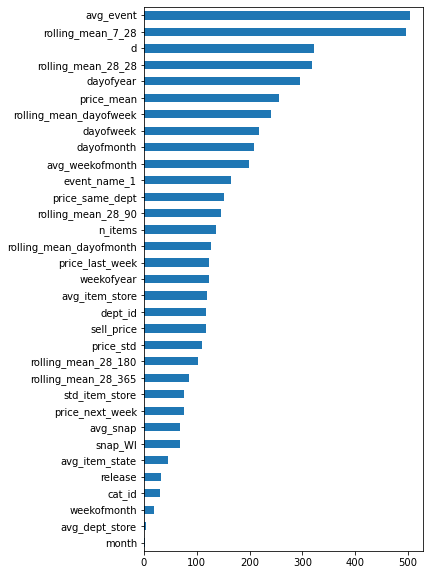

In [400]:
plt.figure(figsize=(5,10))
pd.Series(model.feature_importance(), model.feature_name()).sort_values().plot.barh()

In [401]:
model.feature_importance()

array([322, 241, 496, 318, 145, 102,  85, 126, 120,  76,  45,   4,  69,
       503, 198, 137, 118,  31,  33,  19, 123, 218, 208, 296,   2, 164,
        68, 118, 124,  75, 151, 256, 109])

In [402]:
dict(zip(model.feature_name(), model.feature_importance()))

{'d': 322,
 'rolling_mean_dayofweek': 241,
 'rolling_mean_7_28': 496,
 'rolling_mean_28_28': 318,
 'rolling_mean_28_90': 145,
 'rolling_mean_28_180': 102,
 'rolling_mean_28_365': 85,
 'rolling_mean_dayofmonth': 126,
 'avg_item_store': 120,
 'std_item_store': 76,
 'avg_item_state': 45,
 'avg_dept_store': 4,
 'avg_snap': 69,
 'avg_event': 503,
 'avg_weekofmonth': 198,
 'n_items': 137,
 'dept_id': 118,
 'cat_id': 31,
 'release': 33,
 'weekofmonth': 19,
 'weekofyear': 123,
 'dayofweek': 218,
 'dayofmonth': 208,
 'dayofyear': 296,
 'month': 2,
 'event_name_1': 164,
 'snap_WI': 68,
 'sell_price': 118,
 'price_last_week': 124,
 'price_next_week': 75,
 'price_same_dept': 151,
 'price_mean': 256,
 'price_std': 109}

In [403]:
cur_store

'WI_3'

In [404]:
utils.save_model(model, f'm5_{cur_store}.txt')

In [405]:
model = utils.load_model(store=cur_store) #lgbm.Booster(model_file=f'../models/{cur_store}.txt')

In [406]:
cur_store

'WI_3'

In [407]:
y_valid_pred = utils.predict(df, D_PUBLIC, model, x_cols)
print(f'RMSE: {mse(y_valid, y_valid_pred, squared=False):.3f}')

RMSE: 2.049


In [408]:
y_eval_pred = utils.predict(df, D_PRIVATE, model, x_cols)

### submission

In [409]:
valid_submission = utils.partial_submission(df.loc[mask_valid, ['id', 'd']], y_valid_pred)
eval_submission = utils.partial_submission(df.loc[mask_eval, ['id', 'd']], y_eval_pred, eval=True)

submission = pd.concat([valid_submission, eval_submission])

dst = '../partial_submissions'
if not os.path.exists(dst):
    os.makedirs(dst)

submission.to_csv(f'{dst}/m5_{cur_store}.csv', index=False)

#### final sub

In [410]:
final_sub = utils.final_submission()